In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_80.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_930.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_369.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_39.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_717.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_622.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_343.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_891.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_734.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_738.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_149.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_526.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_404.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_111.png
/kaggle/input/mridataset/cleaned/Training/Pituitary/image1_47.pn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import legacy

2024-04-02 18:34:47.865441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 18:34:47.865538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 18:34:47.973563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = '/kaggle/input/mridataset/cleaned/Training/'
test_dir = '/kaggle/input/mridataset/cleaned/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [5]:
sizes = [
    len([x for x in train_labels if x == 'Pituitary']),
    len([x for x in train_labels if x == 'Meningioma']),
    len([x for x in train_labels if x == 'Glioma'])
]
sizes

[744, 566, 1140]

# Visualizing class distribution

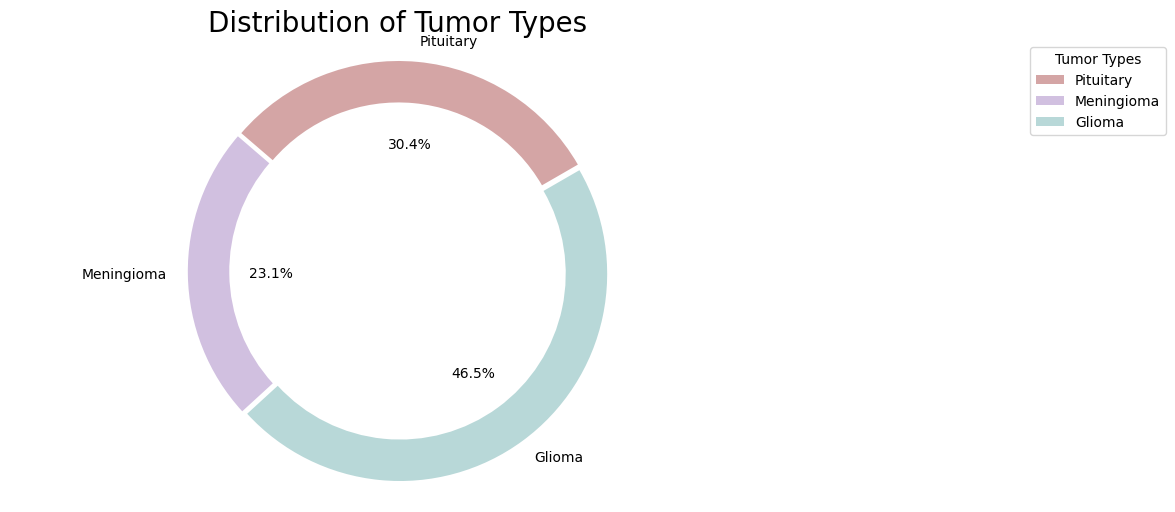

In [6]:
import matplotlib.pyplot as plt

# Data
labels = ['Pituitary',  'Meningioma', 'Glioma']
sizes = [
    len([x for x in train_labels if x == 'Pituitary']),
    len([x for x in train_labels if x == 'Meningioma']),
    len([x for x in train_labels if x == 'Glioma'])
]

# Custom color palette for a brain tumor vibe
colors = ['#D4A5A5', '#D1C0E0', '#B8D8D8']
explode = (0.015, 0.015, 0.015)

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%', explode=explode, startangle=30, wedgeprops=dict(width=0.2))

# Title
plt.title('Distribution of Tumor Types', fontsize=20)

# Add a legend
plt.legend(labels, title='Tumor Types', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

# Distribution of Data between Train and Test Sets

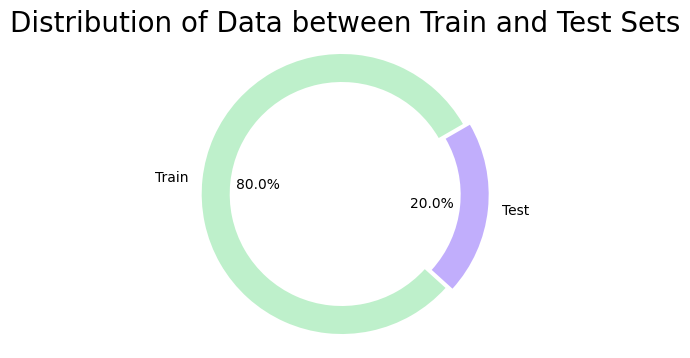

In [7]:
import matplotlib.pyplot as plt

# Data
labels = ['Train', 'Test']
sizes = [len(train_labels), len(test_labels)]
colors = ['#BEF0CB', '#C1AEFC']
explode = (0.05, 0)

# Plotting
plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%', explode=explode, startangle=30, wedgeprops=dict(width=0.2))

# Title
plt.title('Distribution of Data between Train and Test Sets', fontsize=20)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()


In [ ]:
import cv2
image = cv2.imread(train_paths[0])
plt.imshow(image)


In [9]:
image.shape

(256, 256, 3)

# Count of each class

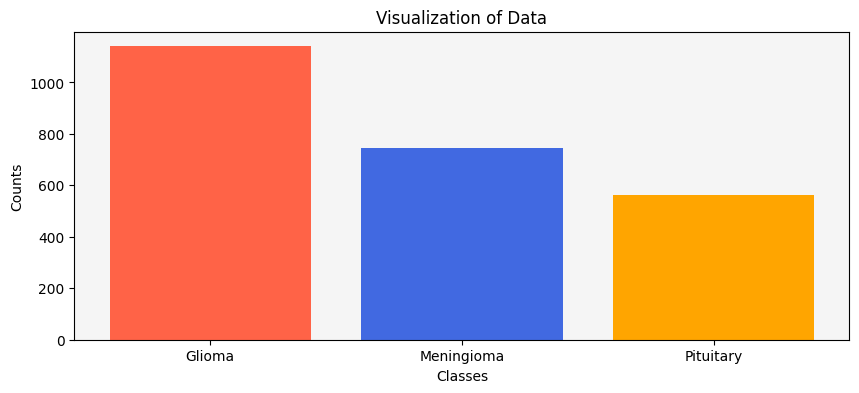

In [10]:
plt.figure(figsize=(10,4))
colors = ['#FF6347',  # Red for glioma
          '#4169E1',  # Blue for meningioma
          '#FFA500']  # Orange for pituitary
plt.bar(['Glioma','Meningioma','Pituitary'],[1140,744,564],color=colors)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Visualization of Data')
plt.gca().set_facecolor('#F5F5F5')
plt.show()

In [11]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [12]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [13]:
tr_df = train_df('/kaggle/input/mridataset/cleaned/Training')
ts_df = test_df('/kaggle/input/mridataset/cleaned/Testing')

# Creating validation dataset

In [14]:
train_df,valid_df = train_test_split(tr_df, train_size=.9, random_state=20)

# Data generators for Image Augmentation

In [15]:
image_size = (256, 256)

# Training batch size
batch_size = 32

SEED=1345

train_datagen=ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)


tr_gen = train_datagen.flow_from_dataframe(train_df, x_col='Class Path',
                                 y_col='Class',
                                 target_size=image_size,seed = SEED,
                                 batch_size=32,
                                 class_mode ='categorical',)

valid_gen = validation_datagen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class',
                                    target_size=image_size,seed = SEED,
                                    batch_size=32,
                                    class_mode ='categorical',)

ts_gen = test_datagen.flow_from_dataframe(ts_df, x_col='Class Path',
                                y_col='Class',
                                 target_size=image_size,shuffle=False,
                                 seed = SEED,
                                 batch_size=32,
                                 class_mode ='categorical',)

Found 2205 validated image filenames belonging to 3 classes.
Found 245 validated image filenames belonging to 3 classes.
Found 614 validated image filenames belonging to 3 classes.


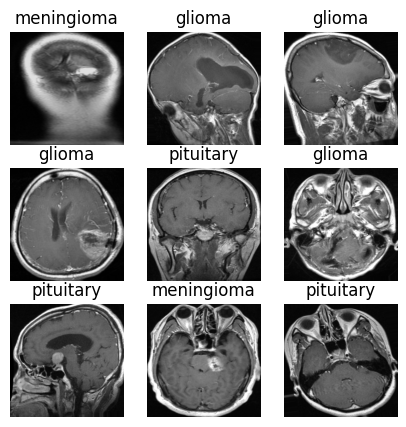

In [16]:
class_names = ['glioma', 'meningioma', 'pituitary']
plt.figure(figsize=(5, 5))
for images, labels in tr_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break

In [17]:
filepath = './cnn_best_weights.hdf5'
earlystopping=EarlyStopping(monitor='val_accuracy',
                           mode='max',
                           patience=15,
                           verbose=1)


callback_list=[earlystopping]

# Model Creation

In [18]:
image_size = (256,256,3)


class_count = len(list(tr_gen.class_indices.keys()))
model = Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_size),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
#     Dropout(0.5, seed=SEED),
    Dense(class_count, activation="softmax")
])
optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 81, 81, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

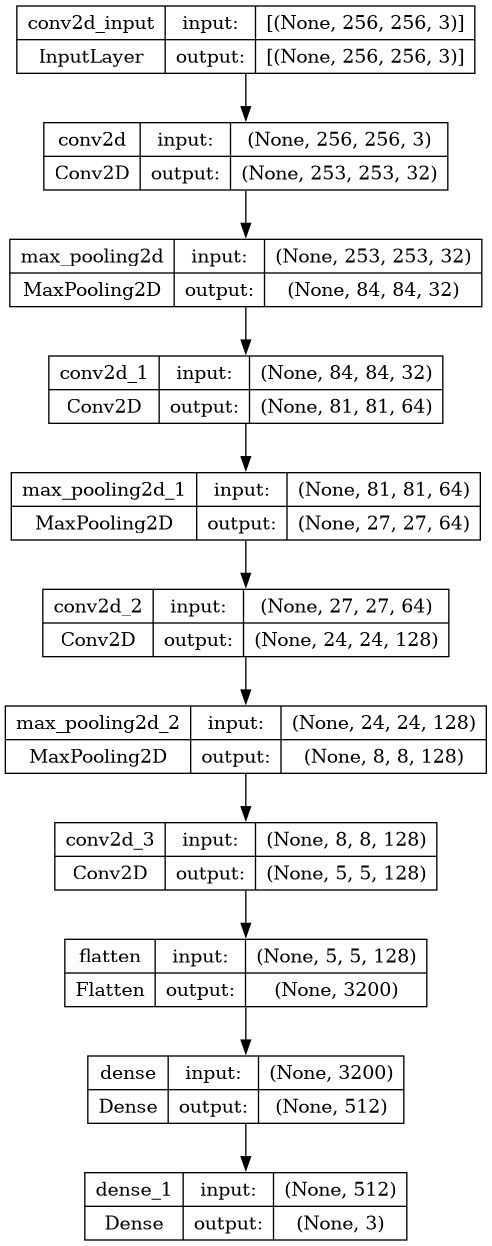

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='modelCNN_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
steps_per_epoch = tr_gen.samples // 32
validation_steps = valid_gen.samples // 32
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_accuracy',
                           mode='max', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(tr_gen,
                    steps_per_epoch=len(tr_gen),
                    epochs=30,verbose = 1,
                    validation_data=valid_gen,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/30
69/69 [==============================] - 66s 901ms/step - loss: 1.0650 - accuracy: 0.4689 - auc: 0.6236 - precision: 0.5022 - recall: 0.1020 - val_loss: 1.1008 - val_accuracy: 0.3884 - val_auc: 0.6019 - val_precision: 0.4296 - val_recall: 0.2589 - lr: 0.0010
Epoch 2/30
69/69 [==============================] - 48s 700ms/step - loss: 0.9435 - accuracy: 0.5556 - auc: 0.7356 - precision: 0.6334 - recall: 0.3565 - val_loss: 0.7781 - val_accuracy: 0.6696 - val_auc: 0.8451 - val_precision: 0.7457 - val_recall: 0.5759 - lr: 0.0010
Epoch 3/30
69/69 [==============================] - 44s 643ms/step - loss: 0.7910 - accuracy: 0.6481 - auc: 0.8224 - precision: 0.6846 - recall: 0.5542 - val_loss: 0.6306 - val_accuracy: 0.7366 - val_auc: 0.8919 - val_precision: 0.7707 - val_recall: 0.7054 - lr: 0.0010
Epoch 4/30
69/69 [==============================] - 44s 637ms/step - loss: 0.6683 - accuracy: 0.7020 - auc: 0.8760 - precision: 0.7398 - recall: 0.6499 - val_loss: 0.5340 - val_accuracy: 0.7

In [22]:
result = model.evaluate(ts_gen)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')

20/20 [==============================] - 5s 275ms/step - loss: 0.1536 - accuracy: 0.9528 - auc: 0.9925 - precision: 0.9527 - recall: 0.9511
Test Loss = 0.15363341569900513
Test Accuracy = 0.9527687430381775
Test AUC = 0.9924721121788025
Test Precision = 0.9526916742324829
Test Recall = 0.9511400461196899


# Model Training Metrics Over Epochs

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall', 'lr'])

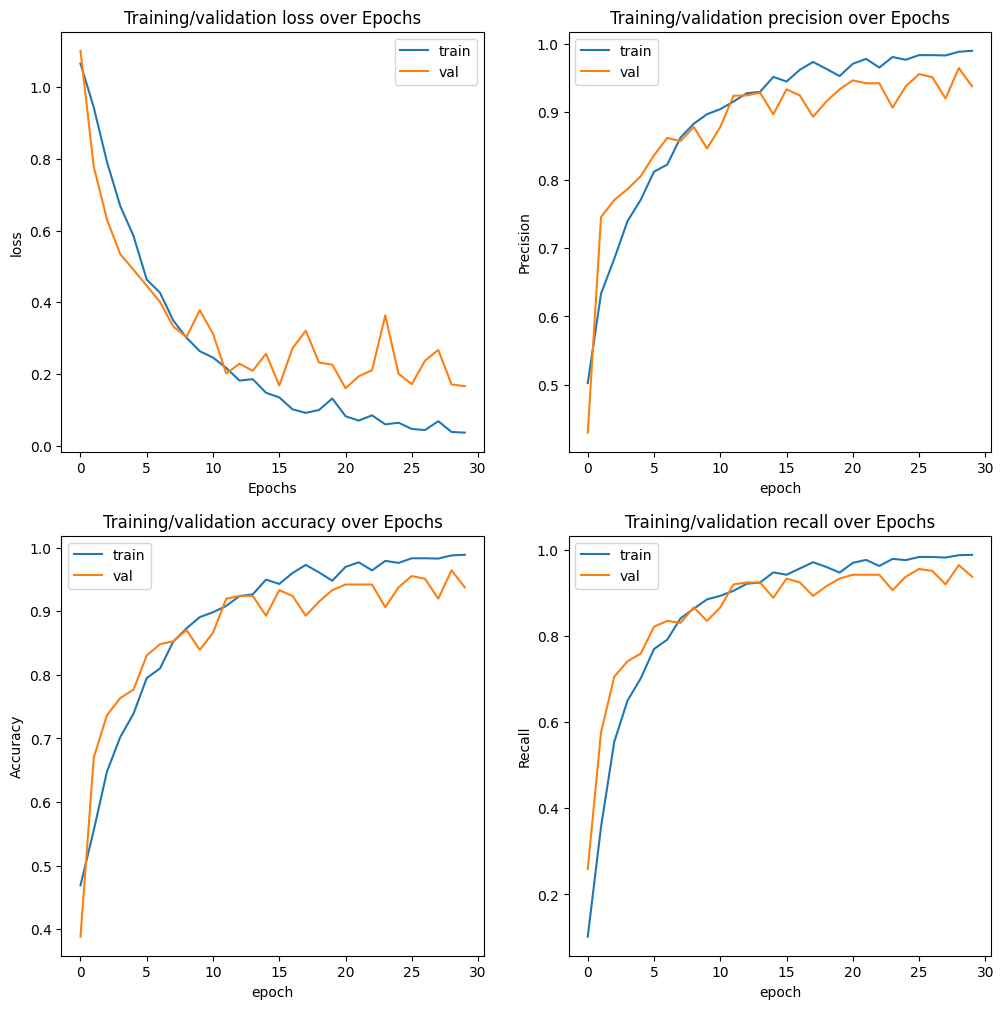

In [24]:
figure , axis = plt.subplots(2,2,figsize=(12,12))

axis[0,0].plot(history.history['loss'] , label='train')
axis[0,0].plot(history.history['val_loss'] , label='val')
axis[0,0].set_title('Training/validation loss over Epochs')
axis[0,0].set_xlabel('Epochs')
axis[0,0].set_ylabel('loss')
axis[0,0].legend()

axis[1,0].plot(history.history['accuracy'], label='train')
axis[1,0].plot(history.history['val_accuracy'], label='val')
axis[1,0].set_title('Training/validation accuracy over Epochs')
axis[1,0].set_xlabel('epoch')
axis[1,0].set_ylabel('Accuracy')
axis[1,0].legend()

axis[0,1].plot(history.history['precision'], label='train')
axis[0,1].plot(history.history['val_precision'], label='val')
axis[0,1].set_title('Training/validation precision over Epochs')
axis[0,1].set_xlabel('epoch')
axis[0,1].set_ylabel('Precision')
axis[0,1].legend()

axis[1,1].plot(history.history['recall'], label='train')
axis[1,1].plot(history.history['val_recall'], label='val')
axis[1,1].set_title('Training/validation recall over Epochs')
axis[1,1].set_xlabel('epoch')
axis[1,1].set_ylabel('Recall')
axis[1,1].legend()

# Test data predictions

In [25]:
test_label=ts_gen.classes
Y_pred=model.predict(ts_gen)
y_pred=[]
[y_pred.append(np.argmax(l)) for l in Y_pred ]

20/20 [==============================] - 3s 119ms/step


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [26]:
y_pred=np.array(y_pred)

# Confusion Matrix

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report = classification_report(test_label, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       286
           1       0.90      0.91      0.91       142
           2       0.97      0.98      0.98       186

    accuracy                           0.95       614
   macro avg       0.95      0.95      0.95       614
weighted avg       0.95      0.95      0.95       614



<Figure size 800x600 with 0 Axes>

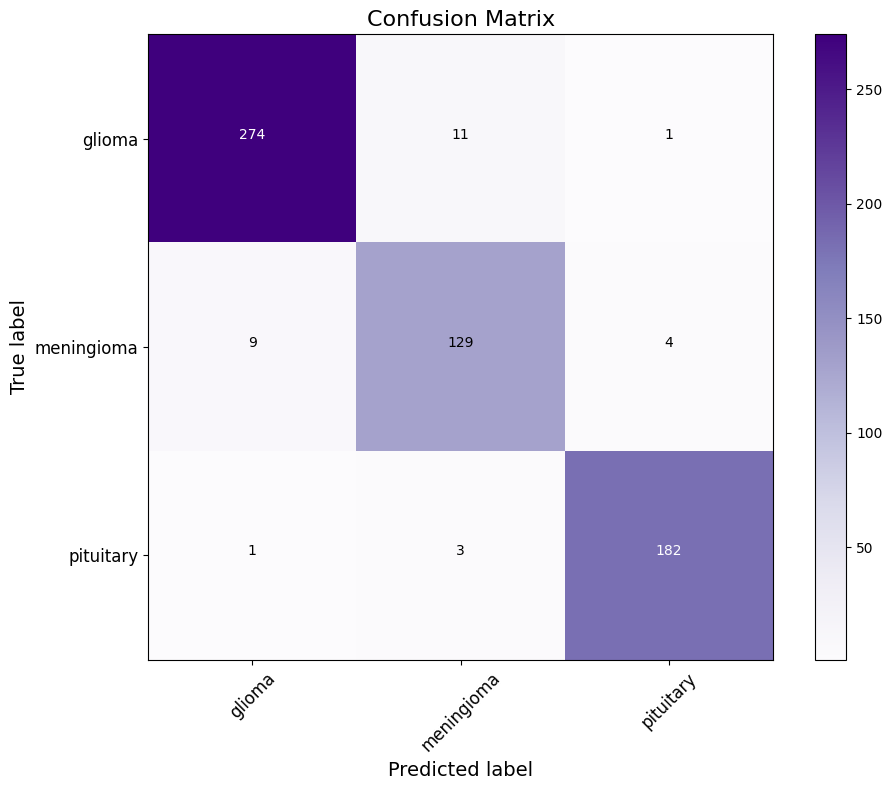

In [28]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()

# Example confusion matrix
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names)
plt.show()


In [29]:
model.save('CNN.h5')

In [30]:

cm = confusion_matrix(test_label, y_pred)
cm

array([[274,  11,   1],
       [  9, 129,   4],
       [  1,   3, 182]])